In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import qiskit
from qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_state
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QuantumProgram
from qiskit import available_backends, execute

In [2]:
def n_controlled_Z_12(circuit, controls, target):
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is implemented as different function')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)


def n_controlled_Z(circuit, controls, target, aux):
    if len(controls) <= 2:
        n_controlled_Z_12(circuit, controls, target)
    else:
        # Left.
        circuit.ccx(controls[1], controls[2], aux[0])
        for k, control_qubit in enumerate(controls[3:], 1):
            circuit.ccx(control_qubit, aux[k - 1], aux[k])
        # Center.
        n_controlled_Z_12(circuit, [controls[0], aux[len(controls[3:])]], target)
        # Right.
        for k, control_qubit in enumerate(reversed(controls[3:]), 1):
            circuit.ccx(control_qubit, aux[len(controls[3:]) - k], aux[len(controls[3:]) - k + 1])
        circuit.ccx(controls[1], controls[2], aux[0])


def input_state(circuit, f_in):
    circuit.h(f_in)


def black_box_u_f(circuit, f_in, aux, n):
    if n == 2:
        circuit.h(f_in[1])
        circuit.cx(f_in[0], f_in[1])
        circuit.h(f_in[1])


def inversion_about_average(circuit, f_in, n):
    circuit.h(f_in)
    circuit.x(f_in)
    
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])

    circuit.x(f_in)
    circuit.h(f_in)

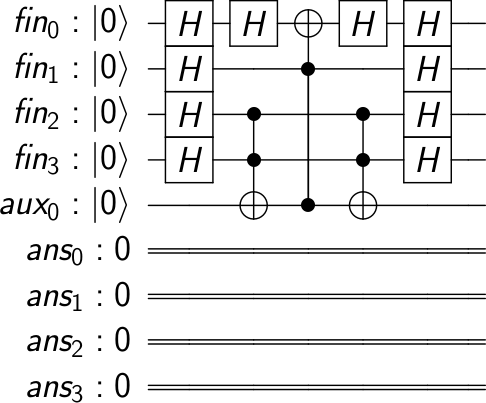

In [9]:
n = 4  # Number of qubits.
f_in = QuantumRegister(n, name='fin')
c = ClassicalRegister(n, name='ans')

target = f_in[0]
controls = [f_in[i] for i in range(1, 4)]

aux = None
qc = None
if len(controls) > 2:
    aux = QuantumRegister(len(controls) - 2, name='aux')
    qc = QuantumCircuit(f_in, aux, c, name='grover')
else:
    qc = QuantumCircuit(f_in, c, name='grover')
    
qc.h(f_in)
n_controlled_Z(qc, controls, target, aux)
qc.h(f_in)

circuit_drawer(qc)

In [10]:
n_ctl = len(controls) + 1  # Number of controls.
statevector = execute(qc, backend='local_statevector_simulator_py', shots=1).result().get_data()['statevector']
statevector = statevector[:2 ** n_ctl]
statevector

array([ 0.875-3.97216229e-16j,  0.125+2.92587421e-17j,
        0.125-1.34254504e-16j, -0.125+1.82696410e-16j,
        0.125+1.60692087e-17j, -0.125+1.82696410e-16j,
       -0.125+1.85689438e-16j,  0.125-1.76472665e-16j,
        0.125-3.55694708e-18j, -0.125+1.82696410e-16j,
       -0.125+2.05315594e-16j,  0.125-1.76472665e-16j,
       -0.125+4.16208151e-17j,  0.125-1.90350452e-16j,
        0.125-2.15113000e-16j, -0.125+1.68818622e-16j])

You can check results [here](http://algassert.com/quirk#circuit={"cols":[["H","H","H","H"],["Z","•","•","•"],["H","H","H","H"]]}).

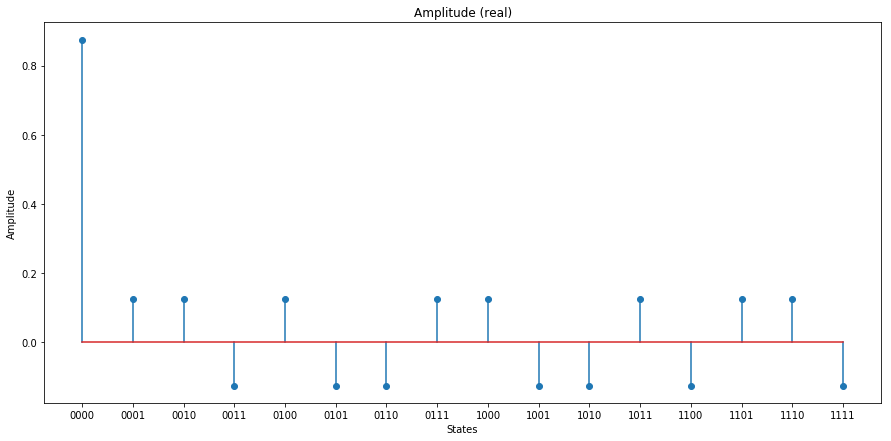

In [11]:
plt.figure(figsize=(15, 7))
x = np.arange(1, 1 + 2 ** n_ctl)
states = list(map(lambda x: ''.join(map(str, x)), itertools.product([0, 1], repeat=n_ctl)))
plt.stem(x, statevector.real)
plt.xticks(x, states)
plt.title('Amplitude (real)')
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.show()